<img src="../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# Quantum Circuit Properties

In this tutorial we introduce the fundamental properties of quantum circuits, and the situations under which these properties may change.

## Table of contents

1) [Introduction](#introduction)


2) [Circuit Depth](#depth)


3) [Circuit Unitary Factors](#unitary)


4) [Circuits with Classical Registers](#classical)


5) [Gate Set Dependence of Depth](#gate_dependence)


In [1]:
from qiskit import *
%matplotlib inline

## Introduction <a name='introduction'></a>

When constructing quantum circuits, there are several properties that help quantify the "size" of the circuits, and their ability to be run on a noisy quantum device.  Some of these, like number of qubits, are straightforward to understand, while others like depth and number of tensor components require a bit more explanation.  Here we will explain all of these properties, and, in preparation for understanding how circuits change when run on actual devices, highlight the conditions under which they change.


### Basics
Consider the following circuit:

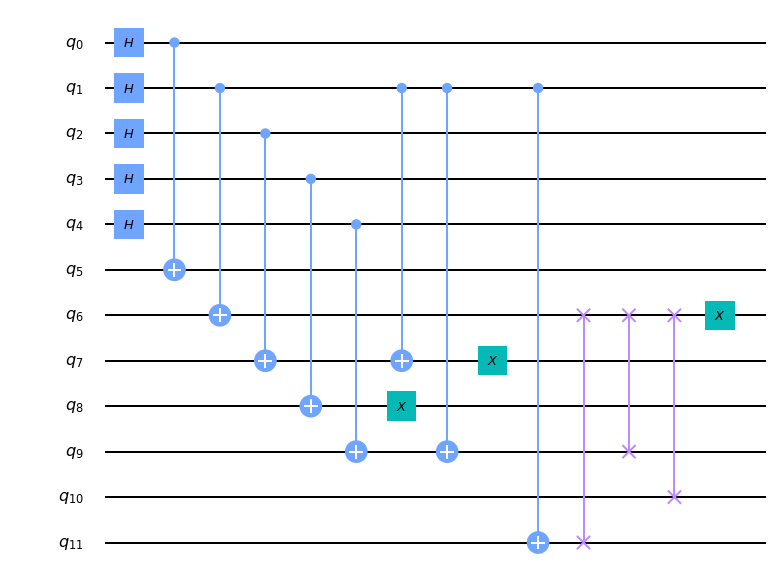

In [3]:
qc = QuantumCircuit(12)

for idx in range(5):
    qc.h(idx)
    qc.cx(idx, idx+5)

qc.cx(1, 7)
qc.x(8)
qc.cx(1, 9)
qc.x(7)
qc.cx(1, 11)
qc.swap(6, 11)
qc.swap(6, 9)
qc.swap(6, 10)
qc.x(6)
qc.draw()

From the plot, it is easy to see that this circuit has 12 qubits, and a collection of Hadamard, CNOT, X, and SWAP gates.  But how to quantify this programmatically? Because we can do single-qubit gates on all the qubits simultaneously, the number of qubits in this circuit is equal to the **width** of the circuit:

In [4]:
qc.width()

12

<div class="alert alert-block alert-warning">
<b>Warning:</b> For a quantum circuit composed from just qubits, the circuit width is equal to the number of qubits.  This is the definition used in quantum computing.  However, for more complicated circuits with classical registers, and classically controlled gates, this equivalence breaks down.  As such, from now on we will <b>not</b> refer to the number of qubits in a quantum circuit as the width.
</div>

We can also just get the number of qubits directly:

In [5]:
qc.n_qubits

12

It is also straightforward to get the number and type of the gates in a circuit using `count_ops()`:

In [6]:
qc.count_ops()

OrderedDict([('cx', 8), ('h', 5), ('x', 3), ('swap', 3)])

We can also get just the raw count of operations by computing the circuits **size**:

In [7]:
qc.size()

19

## Quantum Circuit Depth <a name="depth"></a>

A particularly important circuit property is known as the **depth**.  The depth of a quantum circuit is a measure of how many "layers" of quantum gates, executed in parallel, it takes to complete the computation defined by the circuit.  Because quantum gates take time to implement, the depth of a circuit roughly corresponds to the amount of time it takes the quantum computer to execute the circuit.  Thus, the depth of a circuit is one important quantity used to measure if a quantum circuit can be run on a device.

The depth of a quantum circuit has a mathematical definition as the longest path in a directed acyclic graph (DAG).  However, such a definition is a bit hard to grasp, even for experts.  Fortunately, the depth of a circuit can be easily understood by anyone familiar with playing [Tetris](https://en.wikipedia.org/wiki/Tetris).  To understand this, let us redraw the circuit with the first five CNOT gates colored differently for clarity:

<img src="images/depth_1.png" style="max-width:600px;width:100%">

To compute the depth, we turn the circuit counterclockwise so that the beginning of the circuit is at the bottom.  We then let the gates fall to the bottom.  Later gates stack on earlier gates, and multi-qubit gate components must be stacked at the same height.  For the current circuit of interest, this stacking looks like:

<img src="images/depth_2.png" style="max-width:600px;width:100%">

We can see that the first five CNOT gates all collapsed down on top of each other, and are stacked on top of the initial set of Hadamard gates.  The remaining gates stack on top of the CNOT layer as shown.  The stack of gates can be partitioned into "layers", where each layer represents a set of gates that can be executed in parallel on a quantum device (Hardware limitations may restrict the number and/or type of gates that can be run in parallel).  The **depth** of the circuit is just the number of layers in the circuit;  The depth is equal to the height of the stack of gates.  This computation is done for you in qiskit, and we can verify our visual method:

In [7]:
qc.depth()

9

## Unitary Factors <a name="unitary"></a>

The circuit we are focusing on here is a 12 qubit circuit.  However, does this circuit actually require a 12 qubit quantum computer to run?  That is to say, can we compute  the same result by running a collection of smaller circuits individually?

In the limit where only single-qubit gates are performed, it should be clear that each qubit is controlled independently of the rest, and thus we can run each qubit independently and still get the desired result.  Thus, the question becomes are there enough entangling gates in the circuit to have all qubits interacting?  Again, this is best understood in terms of diagrams.  Below, we track the sets of qubits that interact amongst themselves via CNOT gates at each layer in the circuit.

<img src="images/tensor_factors_1.png" style="max-width:600px;width:100%">

We can see that at the end of the computation there are three independent sets of qubits.  Thus, our 12 qubit computation is actual two two qubit calculations and a single eight qubit computation.  We can verify this via qiskit:

In [8]:
qc.num_unitary_factors()

3

## Circuits with Classical Registers and Measurements <a name="classical"></a>

Several of the circuit properties introduced so far change when adding classical registers and measurements.

Lets add measurements to the circuit above.

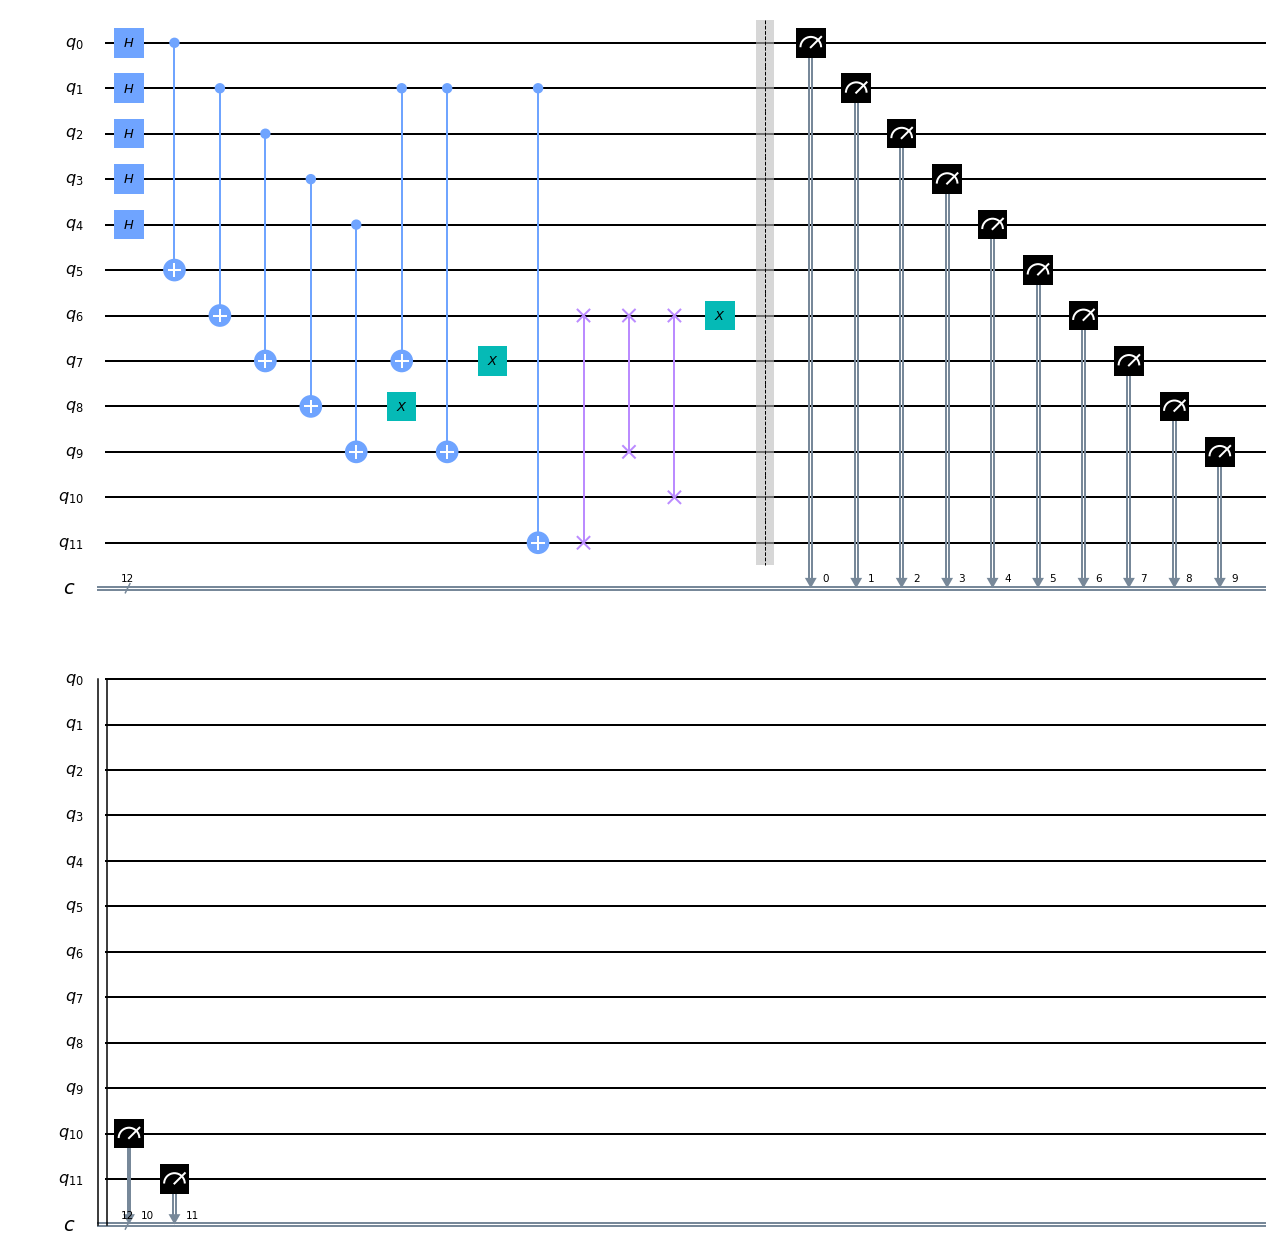

In [10]:
qc2 = QuantumCircuit(12, 12)

for idx in range(5):
    qc2.h(idx)
    qc2.cx(idx, idx+5)

qc2.cx(1, 7)
qc2.x(8)
qc2.cx(1, 9)
qc2.x(7)
qc2.cx(1, 11)
qc2.swap(6, 11)
qc2.swap(6, 9)
qc2.swap(6, 10)
qc2.x(6)
qc2.barrier()
qc2.measure(range(12), range(12))
qc2.draw()

The **width** of the circuit now includes the number of qubits _and_ number of classical bits:

In [16]:
qc2.width()

24

The number of operations has increased because of the measurements and the barrier we used:

In [17]:
qc2.count_ops()

OrderedDict([('measure', 12),
             ('cx', 8),
             ('h', 5),
             ('x', 3),
             ('swap', 3),
             ('barrier', 1)])

and the **size** of the circuit has grown:

In [18]:
qc2.size()

31

The **depth** of the circuit has now increased because measurements are included in the depth computation as they perform physical operations:

In [19]:
qc2.depth()

10

Barriers and other special commands like snapshots do not count towards the depth directly. However, gates cannot pass through them and must therefore start stacking on top.

## Dependence of Depth on Gate Selection <a name="gate_dependence"></a>

We close by highlighting a very important point.  The **depth** of a quantum circuit, and thus the ability to run said circuit on noisy quantum hardware depends on the choice of gates used to implement that circuit.  The original circuit used in this tutorial had a depth of 9.

In [24]:
qc.depth()

9

However, the SWAP gates used in the construction of that circuit are not native to the IBM Q devices.  A decomposition that runs on the devices is a decomposition in terms of three CNOT gates:

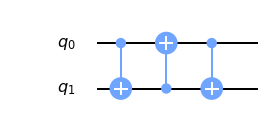

In [23]:
qc3 = QuantumCircuit(2)
qc3.swap(0,1)
qc3.decompose().draw() # This decomposes the swap gate into the gates we want

So the exact same circuit could be written as:

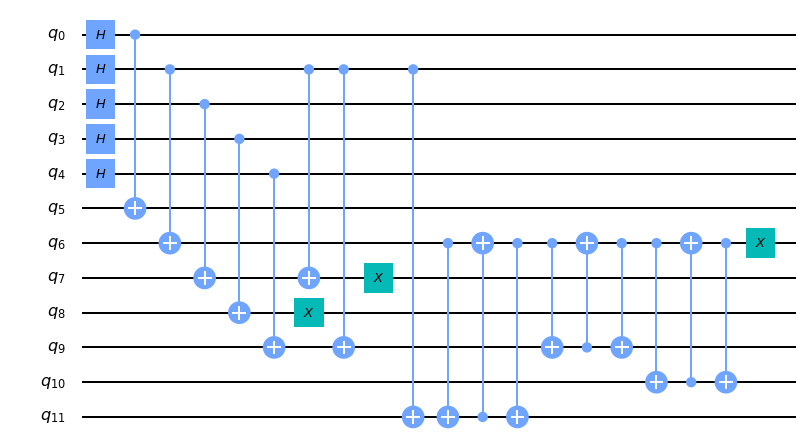

In [16]:
qc4 = QuantumCircuit(12)

for idx in range(5):
    qc4.h(idx)
    qc4.cx(idx, idx+5)

qc4.cx(1, 7)
qc4.x(8)
qc4.cx(1, 9)
qc4.x(7)
qc4.cx(1, 11)

qc4.cx(6, 11)
qc4.cx(11, 6)
qc4.cx(6, 11)

qc4.cx(6, 9)
qc4.cx(9, 6)
qc4.cx(6, 9)

qc4.cx(6, 10)
qc4.cx(10, 6)
qc4.cx(6, 10)

qc4.x(6)
qc4.draw()

That has a depth approaching twice that of the original circuit

In [17]:
qc4.depth()

15

This simple example is meant to illustrate a very important point: **When running circuits on actual quantum devices, the circuit that gets run is in general not the same circuit that you constructed**.  In addition, the depth of that new circuit is likely to be larger, and in some cases much larger, than the original one.  Fortunately, often times one can reduce this overhead through smart circuit rewriting toolchains.

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright